In [1]:
import ssm_read_data
import pandas
import numpy
import datetime
import aacgmv2
import os
os.environ["CDF_LIB"] = "cdf36_4-dist/lib"
from spacepy import pycdf
import seaborn as sns
import matplotlib.pyplot as plt
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# SSM File
selSsmFile = "../data/dmsp/dmsp-f18_ssm_magnetometer_20110705_v1.0.4.cdf"
selTimeRange = [ datetime.datetime(2011,7,5,4,0),\
               datetime.datetime(2011,7,5,4,30) ]
coords = "mlt"
mapTime = datetime.datetime( 2011,7,5,4,30 )

In [3]:
cdf = pycdf.CDF(selSsmFile)
# create a SSMDF
ssmDF = pandas.DataFrame( {
    "date" : cdf['Epoch'][:].flatten(),
    "dB_across" : -1*cdf['DELTA_B_SC'][:,2].flatten(),
    "dB_along" : cdf['DELTA_B_SC'][:,1].flatten(),
    "dB_up" : -1*cdf['DELTA_B_SC'][:,0].flatten(),
    "dBd1" : cdf['DELTA_B_APX'][:,0].flatten(),
    "dBd2" : cdf['DELTA_B_APX'][:,1].flatten(),
    "dBd3" : cdf['DELTA_B_APX'][:,2].flatten(),
    "dB_east" : cdf['DELTA_B_GEO'][:,0].flatten(),
    "dB_north" : cdf['DELTA_B_GEO'][:,1].flatten(),
    "dBUp" : cdf['DELTA_B_GEO'][:,2].flatten(),
    "glat" : cdf['SC_GEOCENTRIC_LAT'][:].flatten(),
    "glon" : cdf['SC_GEOCENTRIC_LON'][:].flatten(),
    "mlat" : cdf['SC_AACGM_LAT'][:].flatten(),
    "mlon" : cdf['SC_AACGM_LON'][:].flatten(),
    "mlt" : cdf['SC_AACGM_LTIME'][:].flatten(),
    "aur_reg" : cdf['AURORAL_REGION'][:].flatten()
} )
# filter ssmDF to required times
ssmDF = ssmDF[ (ssmDF["date"] >= selTimeRange[0]) &\
             (ssmDF["date"] <= selTimeRange[1]) ]

In [4]:
def convert_to_aacgm(row):
        """
        For the SSM DF convert the 
        glat, glon and date return
        mlat, mlon and mlt
        """
        
        mlat, mlon = aacgmv2.convert(row["glat"], row["glon"],\
                           300, row["date"])
        # mlon, mlat = utils.coord_conv( row["glon." + indStr], row["glat." + indStr], \
        #                      "geo", "mag", altitude=300., \
        #                      date_time=row["date"] )
        mlt = aacgmv2.convert_mlt(mlon, row["date"], m2a=False)
        row["mlat"] = numpy.round( mlat, 2)
        row["mlon"] = numpy.round( mlon, 2)
        row["mlt"] = numpy.round( mlt, 2)
        return row

In [5]:
ssmObj = ssm_read_data.ssm_cdf_reader(selSsmFile)

In [6]:
# # create a pandas DF of the data
# ssmDF = pandas.DataFrame( {
#     "date" : ssmObj.cdf['Epoch'][:].flatten(),
#     "dB_across" : ssmObj.dB_across,
#     "dB_along" : ssmObj.dB_along,
#     "dB_up" : ssmObj.dB_up,
#     "dBd1" : ssmObj.dBd1,
#     "dBd2" : ssmObj.dBd2,
#     "dBd3" : ssmObj.dBd3,
#     "glat" : ssmObj.glat,
#     "glon" : ssmObj.glon
# } )
# # filter ssmDF to required times
# ssmDF = ssmDF[ (ssmDF["date"] >= selTimeRange[0]) &\
#              (ssmDF["date"] <= selTimeRange[1]) ]
# #convert to mlat, mlon and mlt
# ssmDF = ssmDF.apply(convert_to_aacgm, axis=1)
# ssmDF.head()

In [7]:
# convert to map coords
if coords != "geo":
    ssmLats = ssmDF["mlat"].values
    if coords == "mlt":
        ssmLons = ssmDF["mlt"].values*15.
    else:
        ssmLons = ssmDF["mlon"].values
else:
    ssmLats = ssmDF["glat"].values
    ssmLons = ssmDF["glon"].values
bVecs = ssmDF["dB_across"].values

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


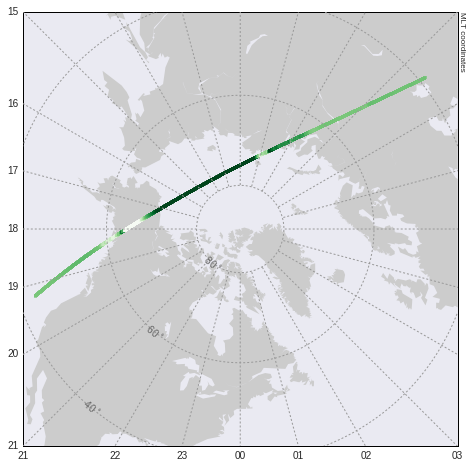

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
mapHandle = utils.plotUtils.mapObj(boundinglat=40., coords=coords,\
                           lat_0=90., lon_0=0, datetime=mapTime)
xVecs, yVecs = mapHandle(ssmLons, ssmLats, coords=coords)
ssmPlot = mapHandle.scatter(xVecs, yVecs, c=bVecs, s=10.,\
                       cmap="Greens", alpha=0.7, zorder=7., \
                                 edgecolor='none', marker="s",\
                           vmin=-100., vmax=100.)

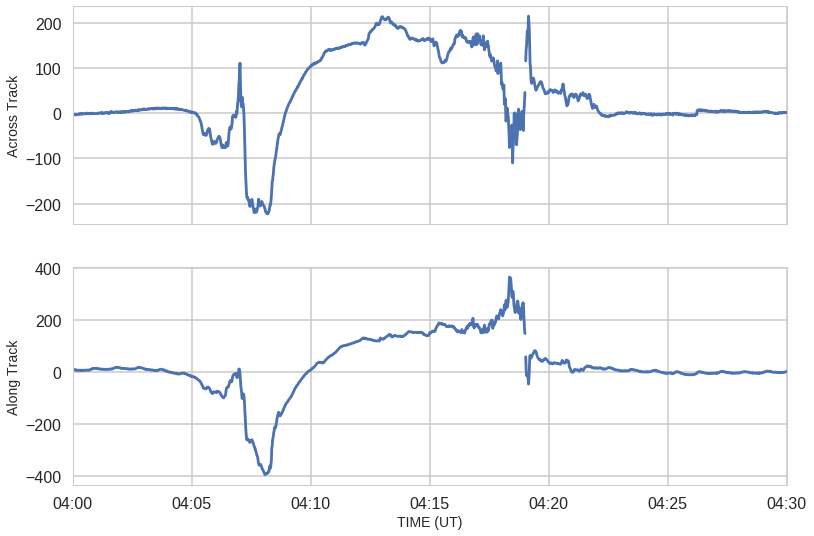

In [11]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f, axArr = plt.subplots(2, sharex=True)
# plot the data
axArr[0].plot(ssmDF["date"].values, ssmDF["dB_across"].values)
axArr[1].plot(ssmDF["date"].values, ssmDF["dB_along"].values)

# ax labels
axArr[0].set_ylabel("Across Track", fontsize=14)
axArr[1].set_ylabel("Along Track", fontsize=14)
# x-label
axArr[1].set_xlabel("TIME (UT)", fontsize=14)
# format the axes
axArr[0].set_xlim( [selTimeRange[0], selTimeRange[1]] )
axArr[1].set_xlim( [selTimeRange[0], selTimeRange[1]] )

axArr[0].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


f.savefig( "../plots/ssm-" + selTimeRange[0].strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )